In [1]:
import os, sys
from data import DatasetFromFolder
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from model import *
from torch.utils.tensorboard import SummaryWriter
from math import log10

UPSCALE_FACTOR = 3
NUM_EPOCHS = 100

In [2]:
current_path, filename = os.path.split('.')
current_path = current_path.replace('\\', '/')
image_dir = os.path.join(current_path, '../../data/VOC2012/')

# ------------------- 数据集 --------------------------------------------
image_dir = image_dir + '/X' + str(UPSCALE_FACTOR)
train_set = DatasetFromFolder(image_dir + '/train',
                                upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
val_set = DatasetFromFolder(image_dir + '/val',
                                upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=64, shuffle=False)

16700
261


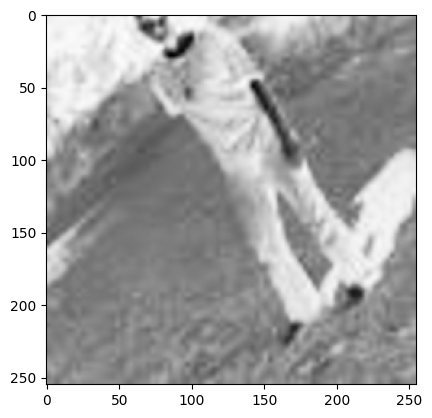

In [3]:
print(len(train_set))
print(len(train_loader))

# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    nping = img.numpy()
    if one_channel:
        plt.imshow(nping, cmap='Greys')
    else:
        plt.imshow(np.transpose(nping, (1, 2, 0)))

img, target = train_set[0]
matplotlib_imshow(img, one_channel=True)

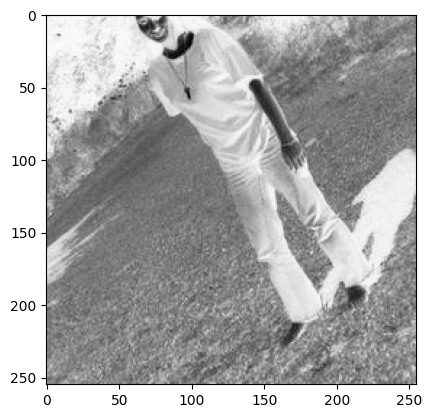

In [4]:
matplotlib_imshow(target, one_channel=True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)  # 设置PyTorch中所有随机数生成器的种子为0
torch.cuda.manual_seed(0) # 设置使用CUDA时的随机数生成器的种子为0

print(device)

cuda


In [6]:
loss_fn = nn.MSELoss()

models = {'SRCNN_9_1_5': SRCNN915(),
          'SRCNN_9_3_5': SRCNN935(),
          'SRCNN_9_5_5': SRCNN955()}

In [7]:
for tag, model in models.items():
    train_step = 0
    val_step = 0
    
    # Initialize network
    model = model.to(device)
    # 优化器
    optimizer = optim.SGD([
        {'params': model.conv1.parameters(), 'lr': 0.0001},
        {'params': model.conv2.parameters(), 'lr': 0.0001},
        {'params': model.conv3.parameters(), 'lr': 0.00001}
    ], lr=0.0001, momentum=0.9)
    
    # 写入tensorboard中
    writer = SummaryWriter(f'runs/SRCNN/{tag}')
    
    # Visualize model in TensorBoard
    images, _ = next(iter(train_loader))
    writer.add_graph(model, images.to(device))
    writer.close()
    
    for epoch in range(NUM_EPOCHS):
        # losses = []
        
        model.train()
        for index, (X, y) in enumerate(train_loader):
            # get data to cuda if possible
            X = X.to(device)
            y = y.to(device)
            
            # forward
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            # losses.append(loss.item())
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            writer.add_scalar('Training loss', loss, global_step=train_step)
            
            train_step += 1
            
    
        model.eval()
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)
                
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                psnr = 10 * log10(1 / loss.item())
                writer.add_scalar('val loss',loss, global_step=val_step)
                writer.add_scalar('psnr',psnr, global_step=val_step)
                val_step += 1
        

In [16]:
current_path, filename = os.path.split('.')
current_path = current_path.replace('\\', '/')
image_dir = os.path.join(current_path, '../../data/')

# ------------------- 数据集 --------------------------------------------
Set5_dir = image_dir + '/Set5' + '/X' + str(UPSCALE_FACTOR)
Set14_dir = image_dir + '/Set14' + '/X' + str(UPSCALE_FACTOR)
Set5_set = DatasetFromFolder(Set5_dir,upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
Set14_set = DatasetFromFolder(Set14_dir,upscale_factor=UPSCALE_FACTOR,
                                input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
Set5_loader = DataLoader(dataset=Set5_set, batch_size=1, shuffle=True)
Set14_loader = DataLoader(dataset=Set14_set, batch_size=1, shuffle=False)

In [18]:
def val(models, dataloader, data_tag):
    for tag, model in models.items():
        psnrs = []
        losses = []
        val_step = 0
        # 写入tensorboard中
        writer = SummaryWriter(f'runs/SRCNN/{tag+data_tag}')
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            for X, y in dataloader:
                X = X.to(device)
                y = y.to(device)
                
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                losses.append(loss.item())
                psnr = 10 * log10(1 / loss.item())
                psnrs.append(psnr)
                
                val_step += 1
        writer.add_hparams(
            {'tag': tag},
            {'hparam/loss': sum(losses)/len(losses),
             'hparam/psnr': sum(psnrs)/len(psnrs)}
        )
        print(f'{tag}_psnr:{psnrs}')
        print(f'{tag}_loss:{losses}')
        writer.flush()

In [19]:
val(models, Set5_loader, 'Set5')
val(models, Set14_loader, 'Set14')

SRCNN_9_1_5_psnr:[26.354130709295205, 22.719936521380024, 24.766738800243413, 18.56402090739029, 24.679626753506923]
SRCNN_9_1_5_loss:[0.002315191552042961, 0.0053457217290997505, 0.0033367688301950693, 0.013918675482273102, 0.0034043744672089815]
SRCNN_9_3_5_psnr:[20.351680884419935, 26.509724147292424, 24.258508420031486, 26.46840057774432, 26.811604094900407]
SRCNN_9_3_5_loss:[0.00922214426100254, 0.002233714098110795, 0.0037510180845856667, 0.0022550695575773716, 0.0020837211050093174]
SRCNN_9_5_5_psnr:[28.908502462742693, 20.911284502917642, 27.960862296782825, 27.86004906891586, 25.08785917069773]
SRCNN_9_5_5_loss:[0.001285729929804802, 0.008107212372124195, 0.0015992404660210013, 0.0016367980279028416, 0.0030989465303719044]
SRCNN_9_1_5_psnr:[20.381166299854975, 23.010474383032822, 21.69843117011395, 22.31732348898263, 18.761932560890806, 26.330692303680916, 22.679906063420944, 22.870980737252722, 25.474963133872826, 22.670269150962497, 23.827935805344108, 25.18510983831706, 18.

## 可视化卷积核

SRCNN_9_1_5_0' kernal shape: torch.Size([64, 1, 9, 9])


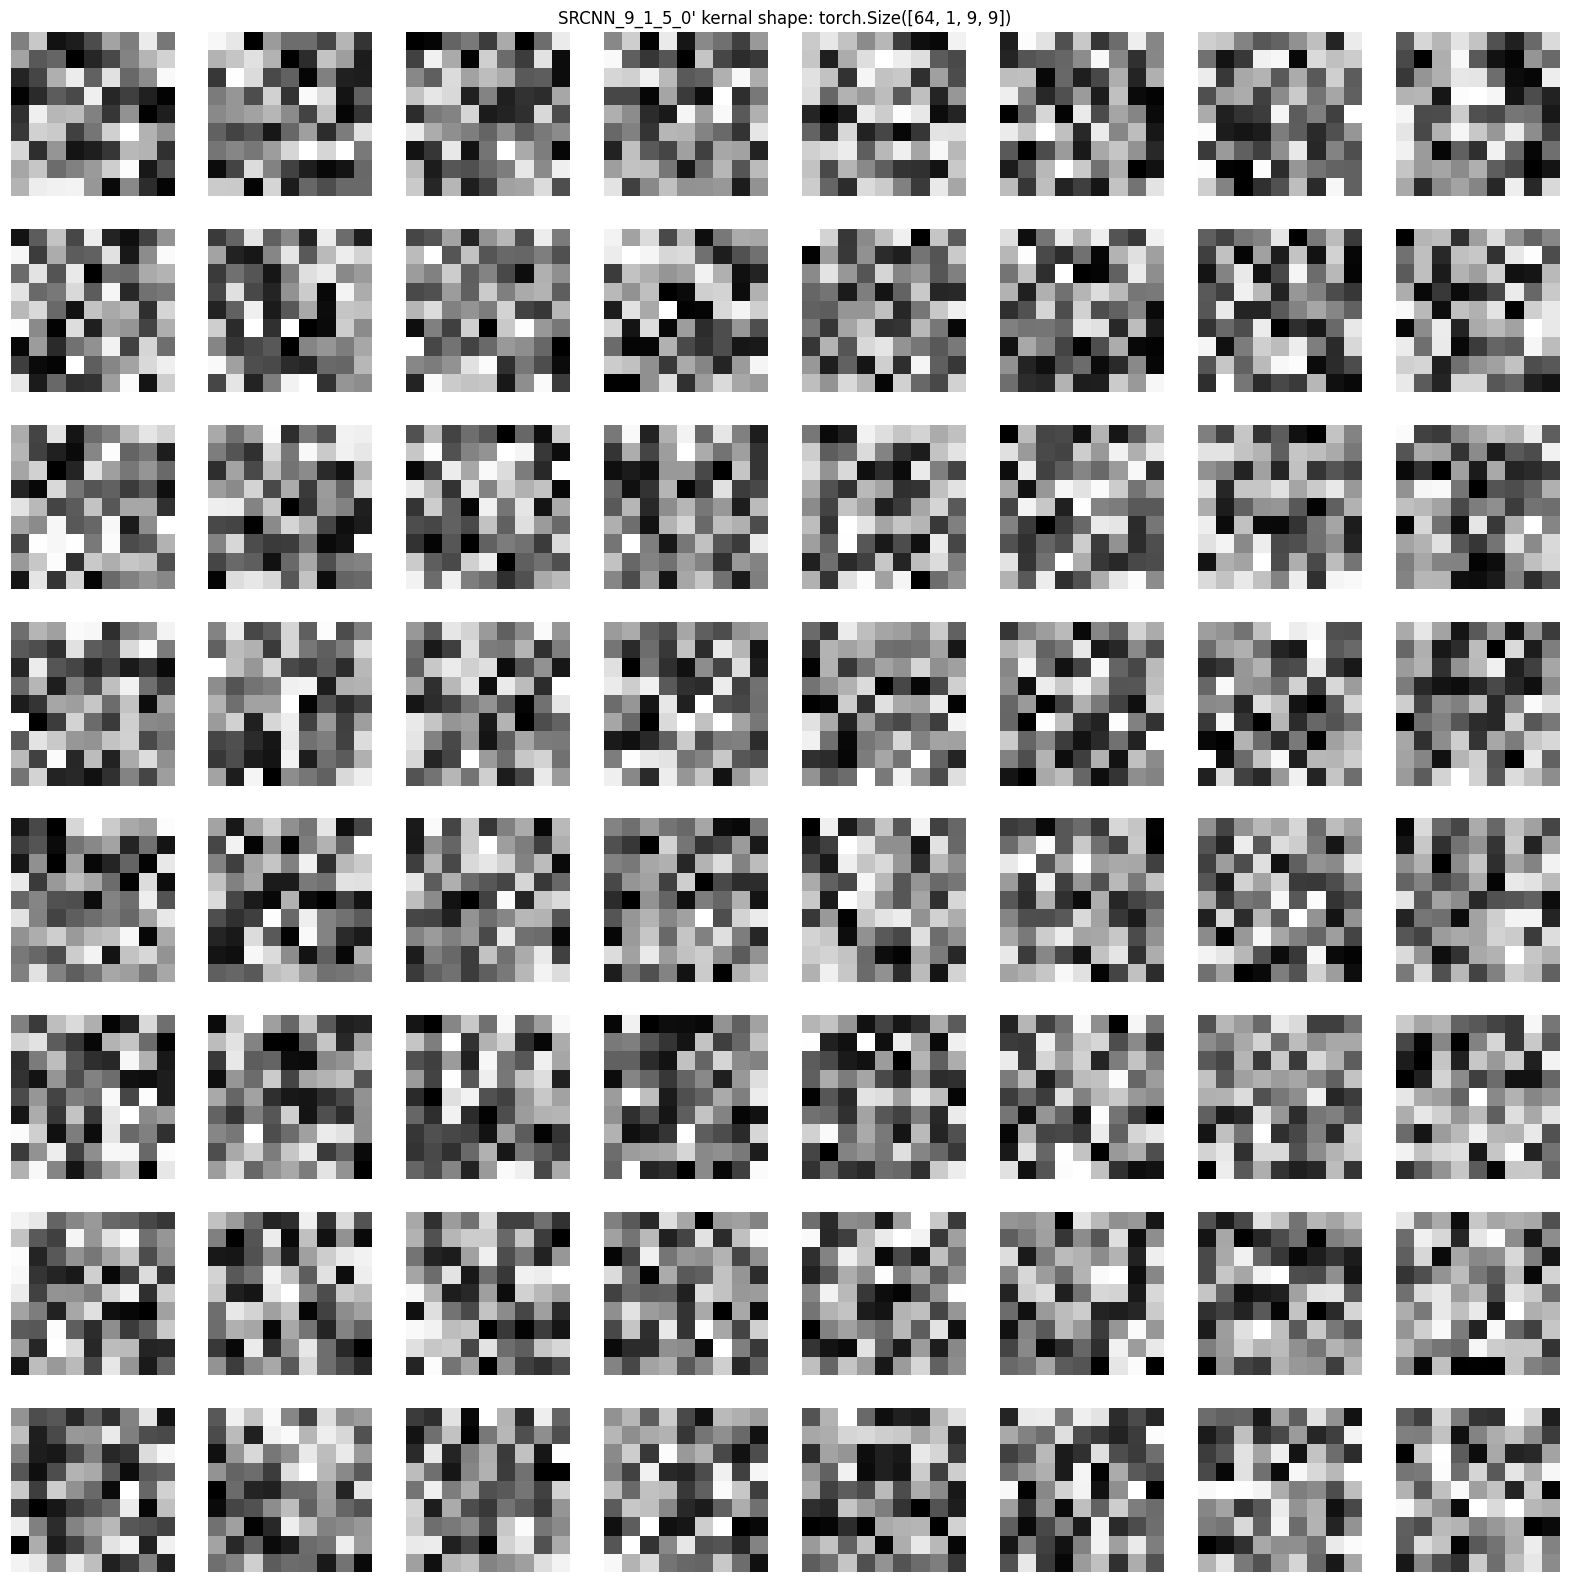

SRCNN_9_1_5_1' kernal shape: torch.Size([32, 64, 1, 1])


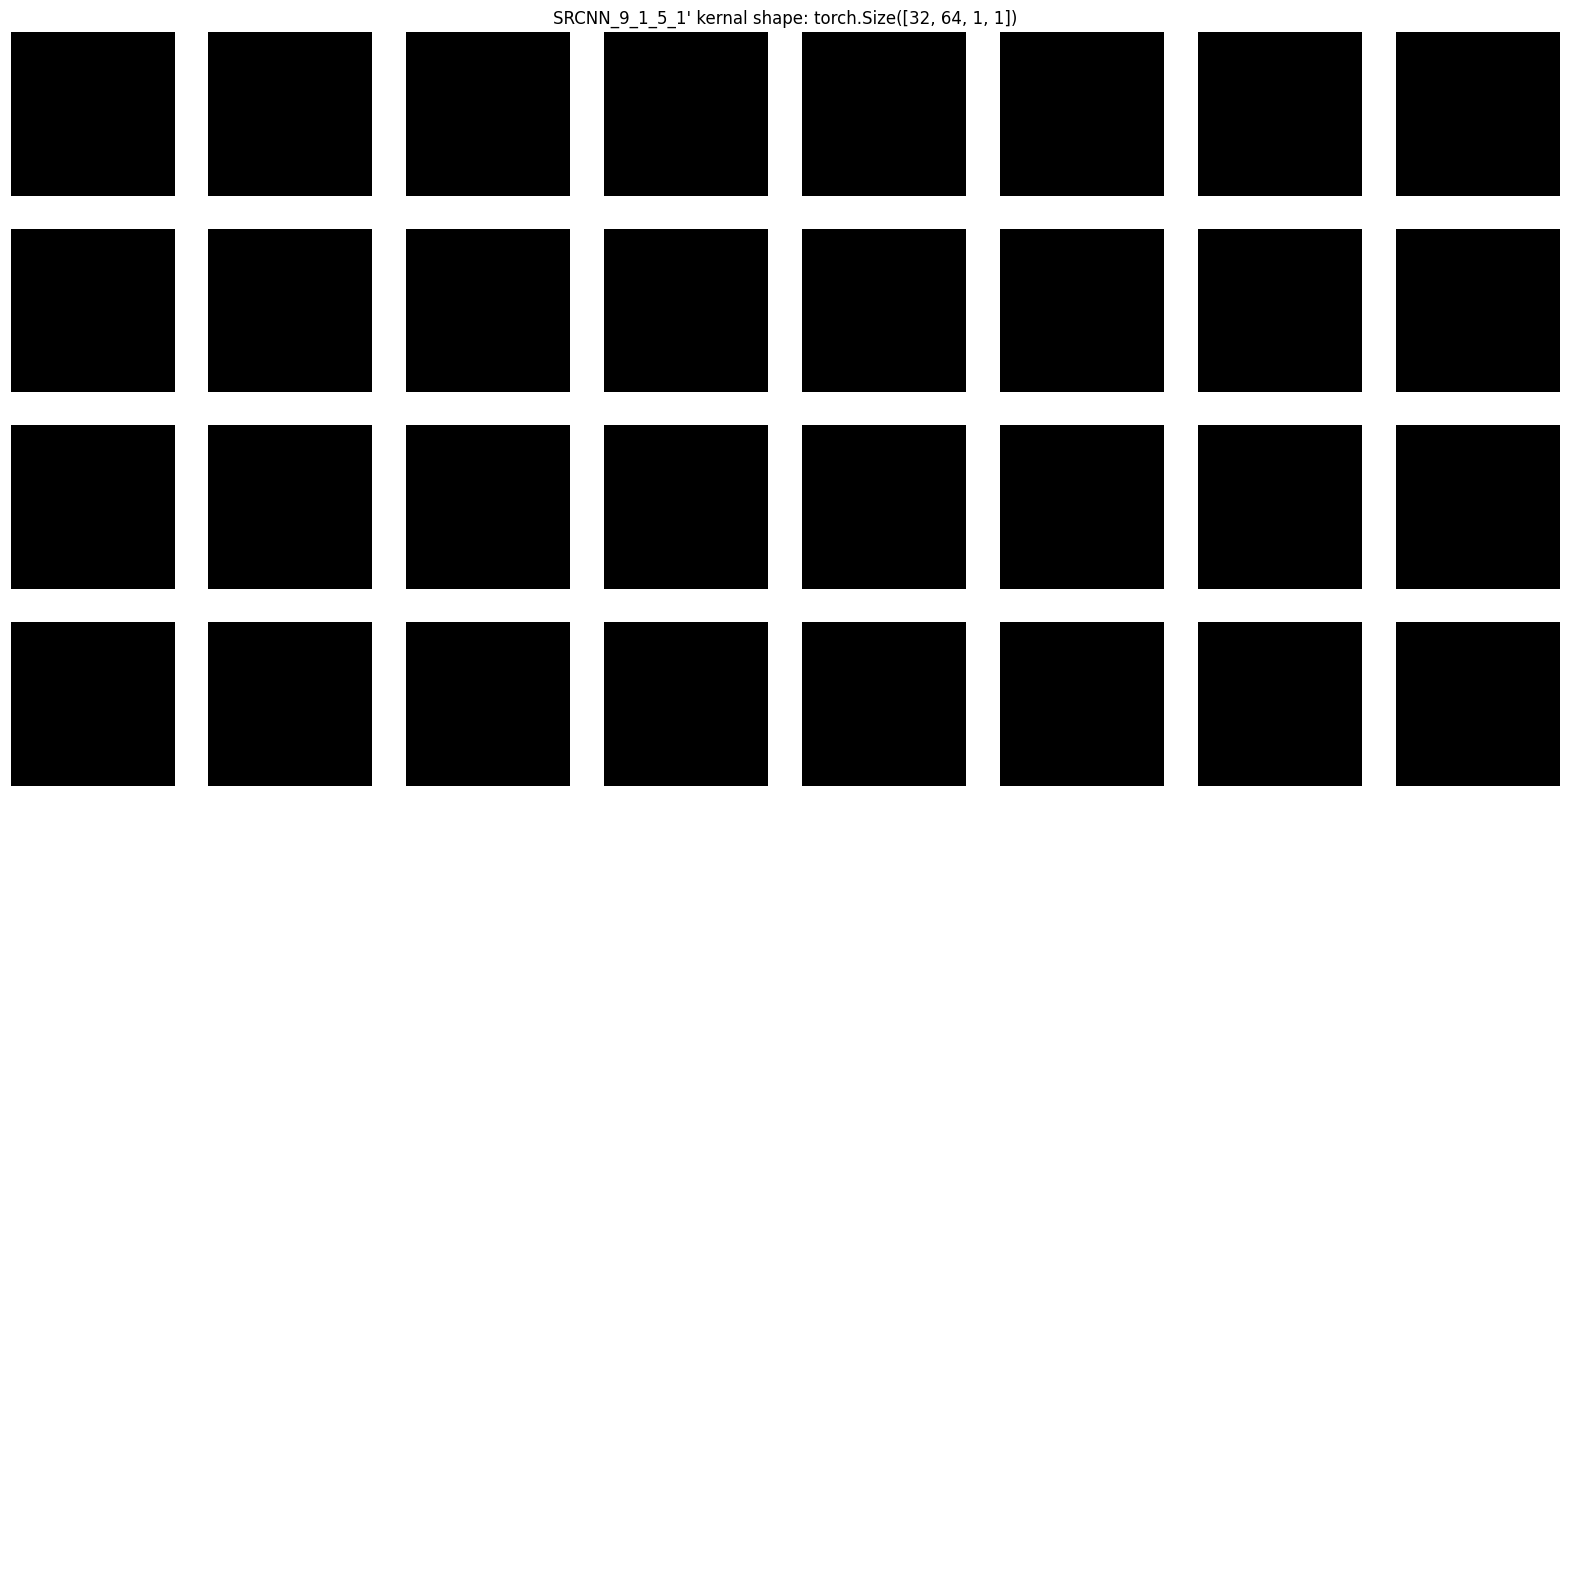

SRCNN_9_1_5_2' kernal shape: torch.Size([1, 32, 5, 5])


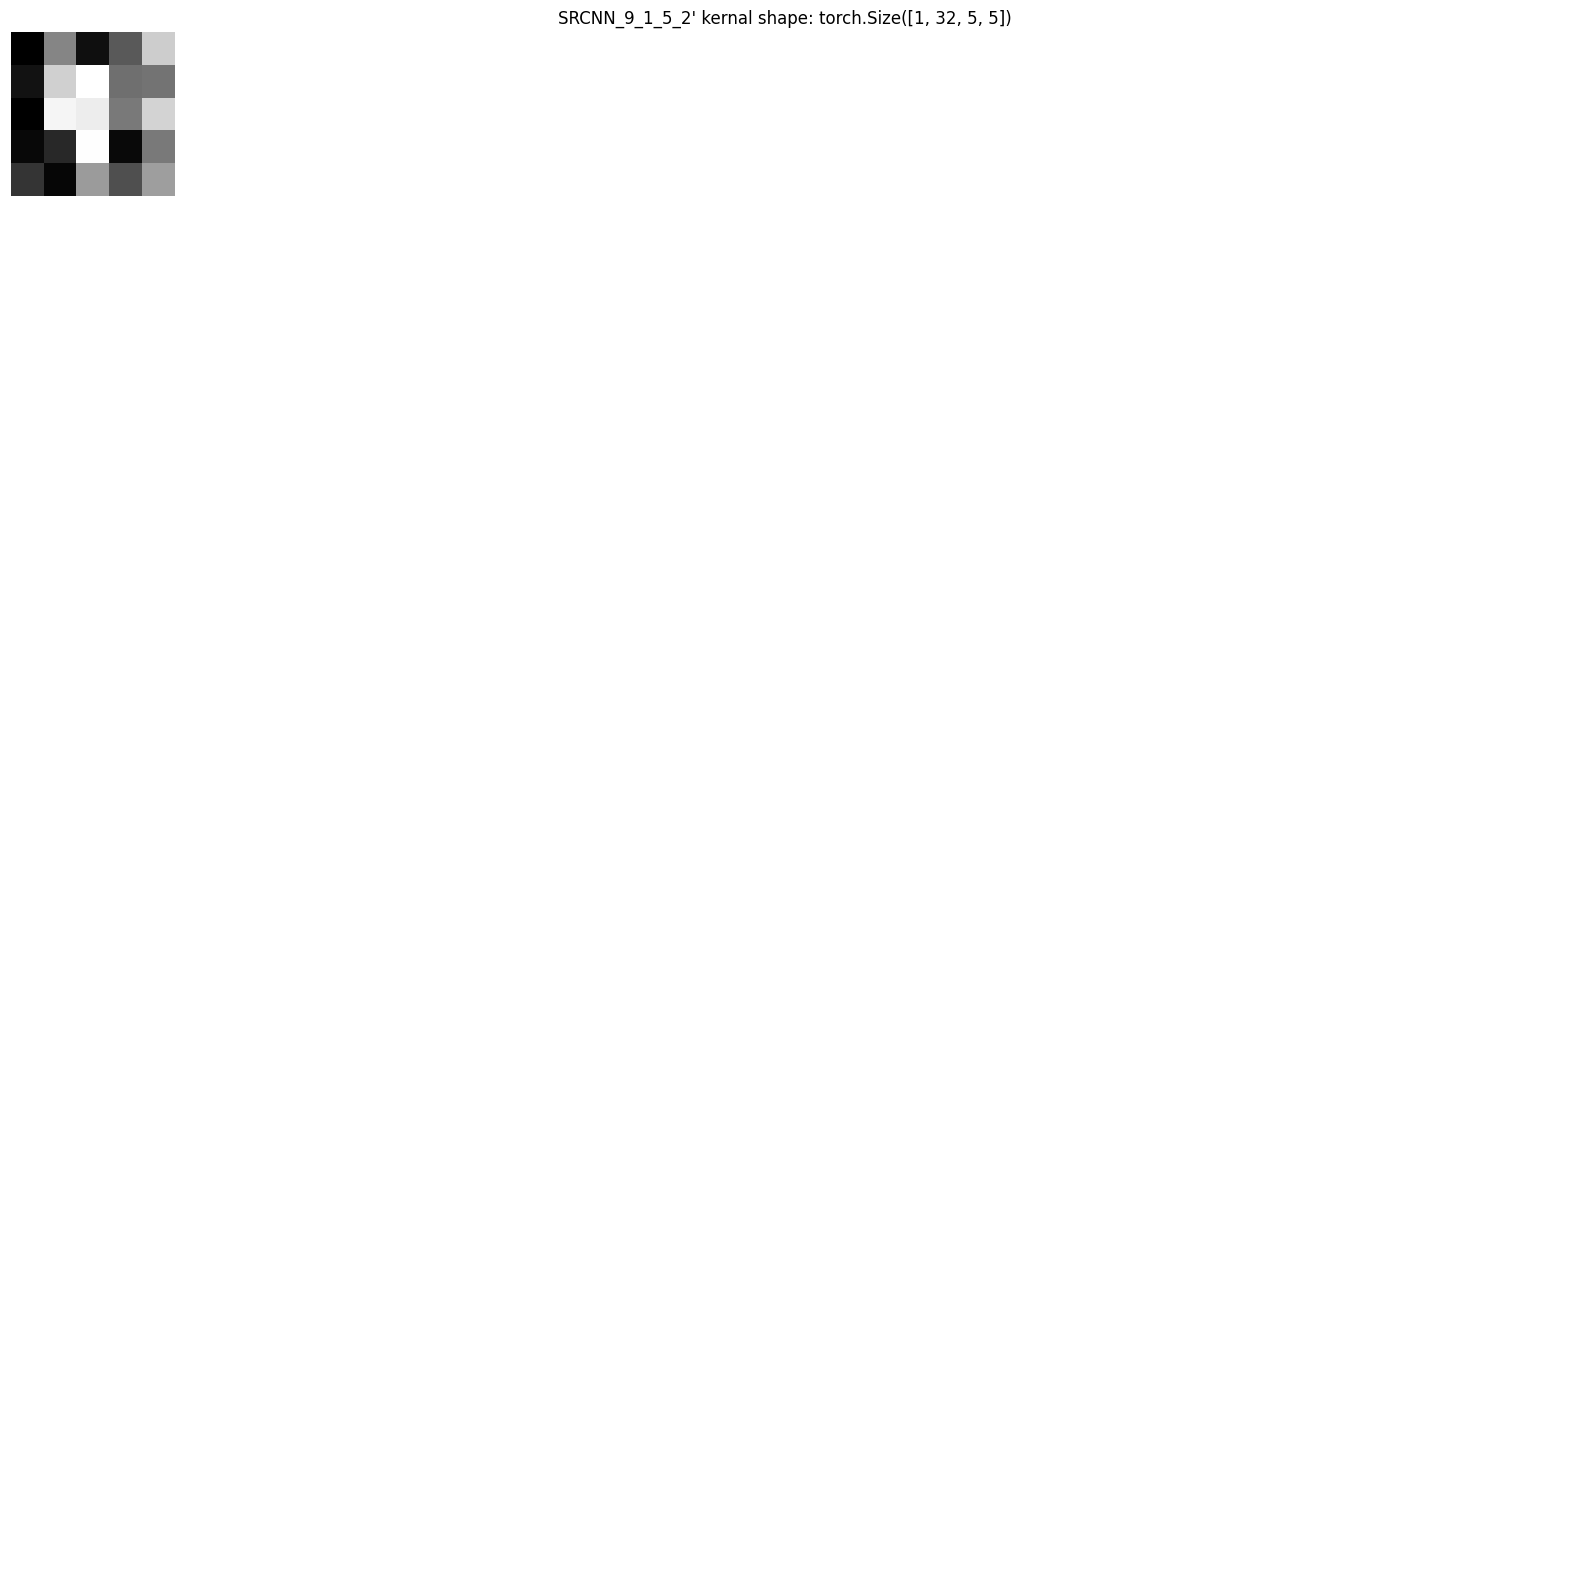

SRCNN_9_3_5_0' kernal shape: torch.Size([64, 1, 9, 9])


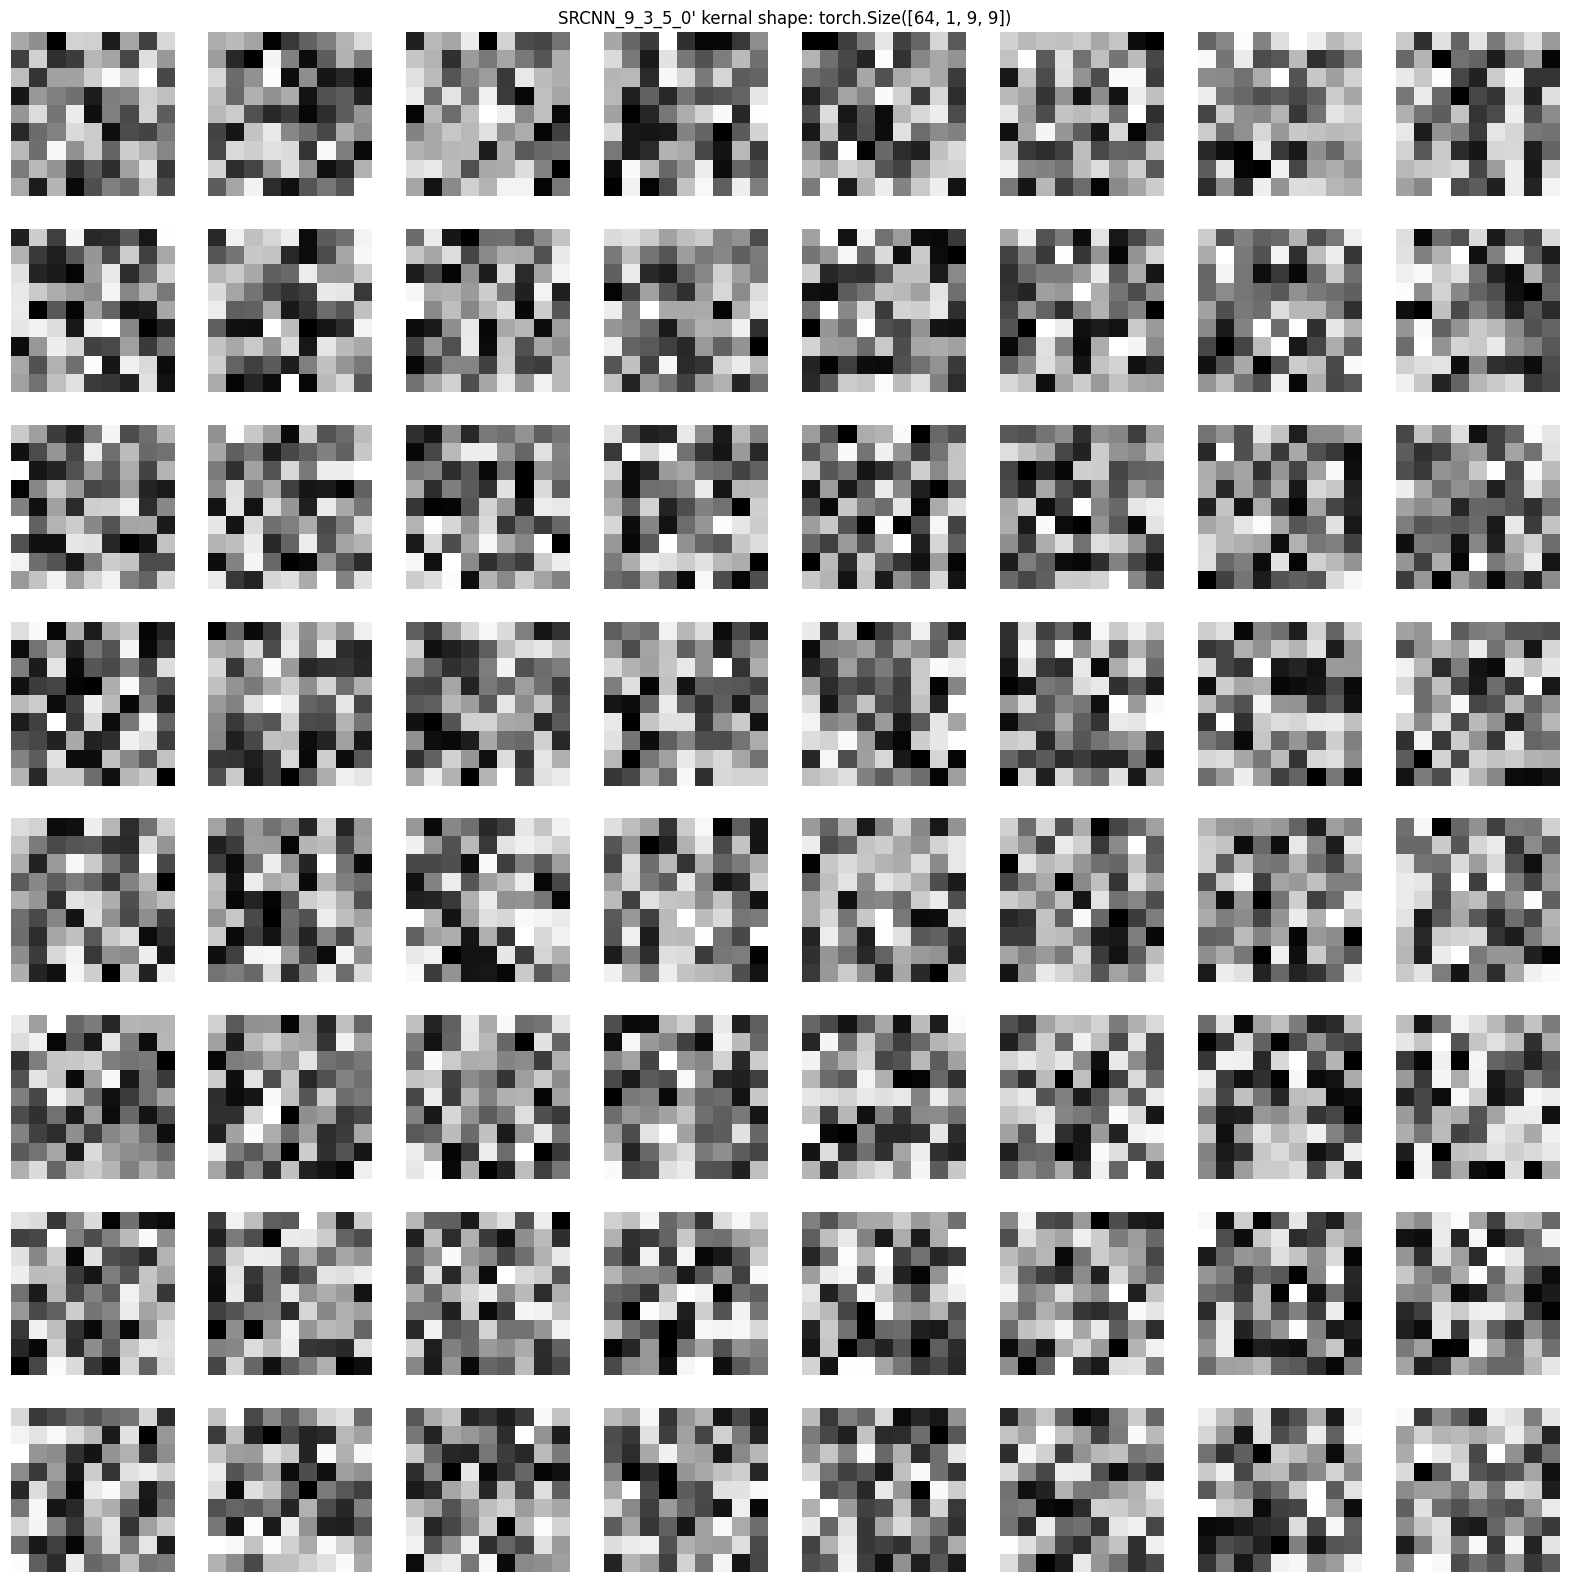

SRCNN_9_3_5_1' kernal shape: torch.Size([32, 64, 3, 3])


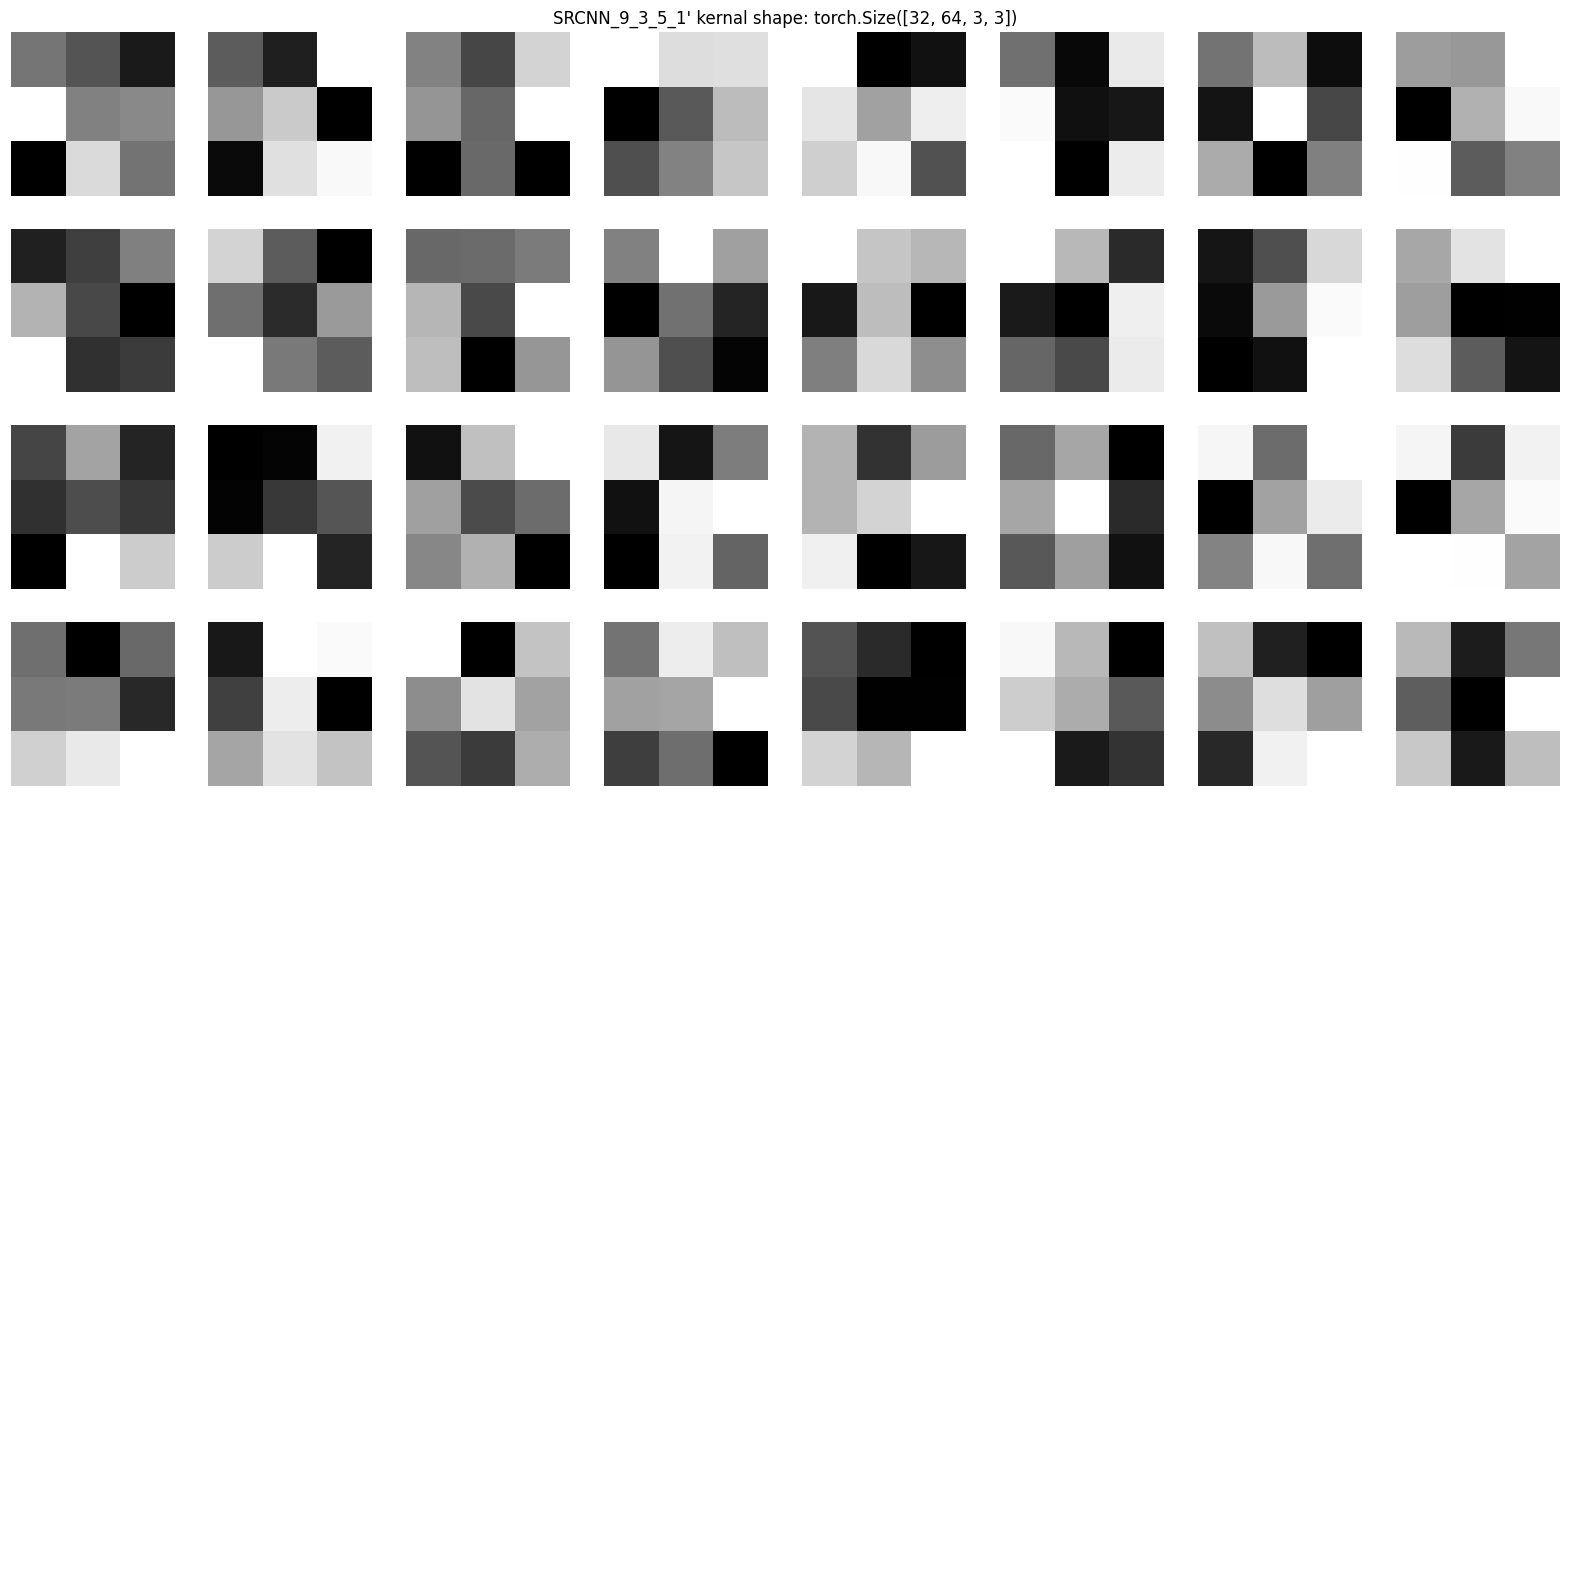

SRCNN_9_3_5_2' kernal shape: torch.Size([1, 32, 5, 5])


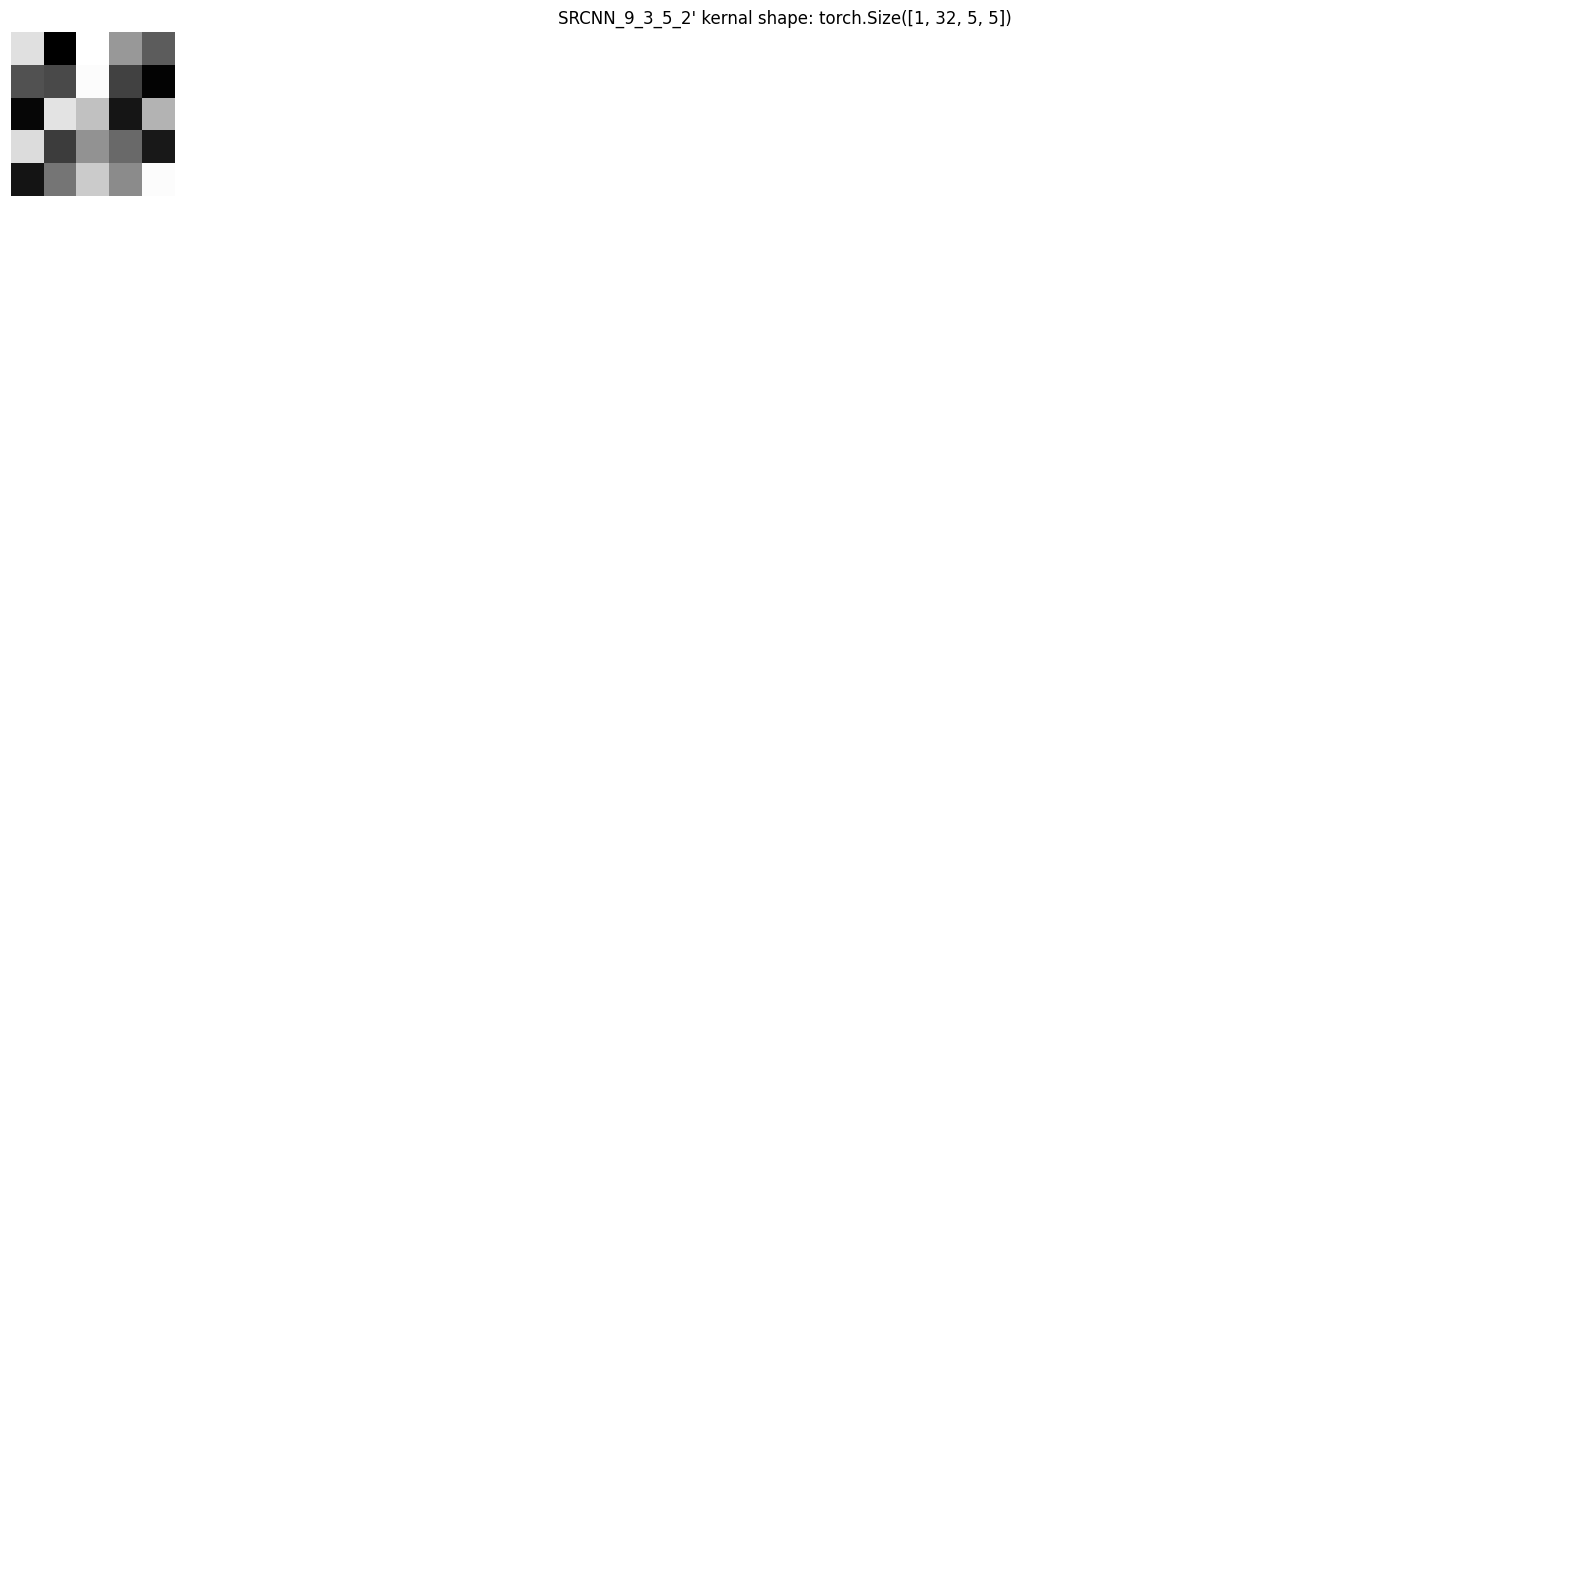

SRCNN_9_5_5_0' kernal shape: torch.Size([64, 1, 9, 9])


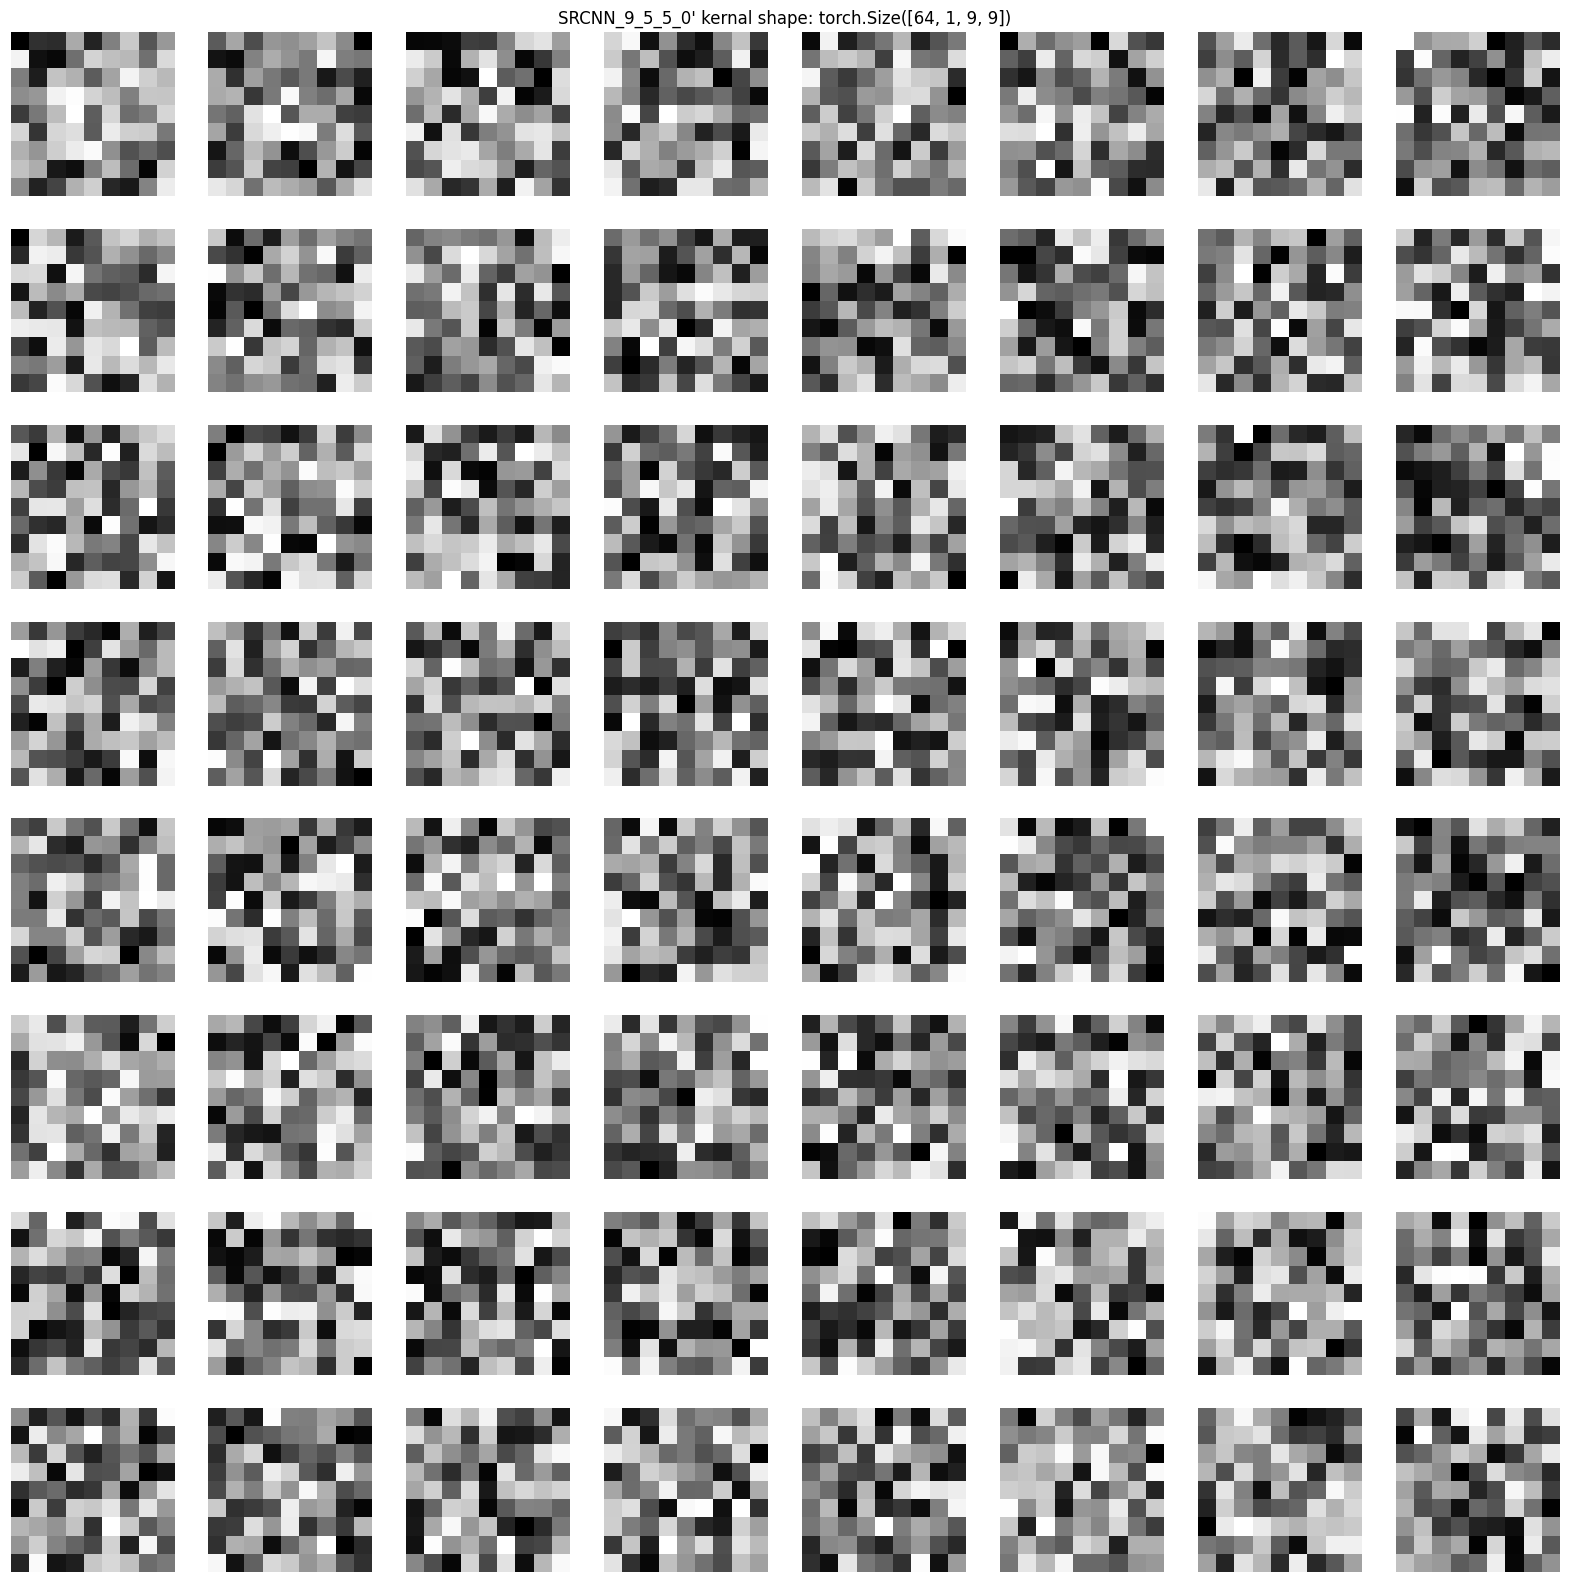

SRCNN_9_5_5_1' kernal shape: torch.Size([32, 64, 5, 5])


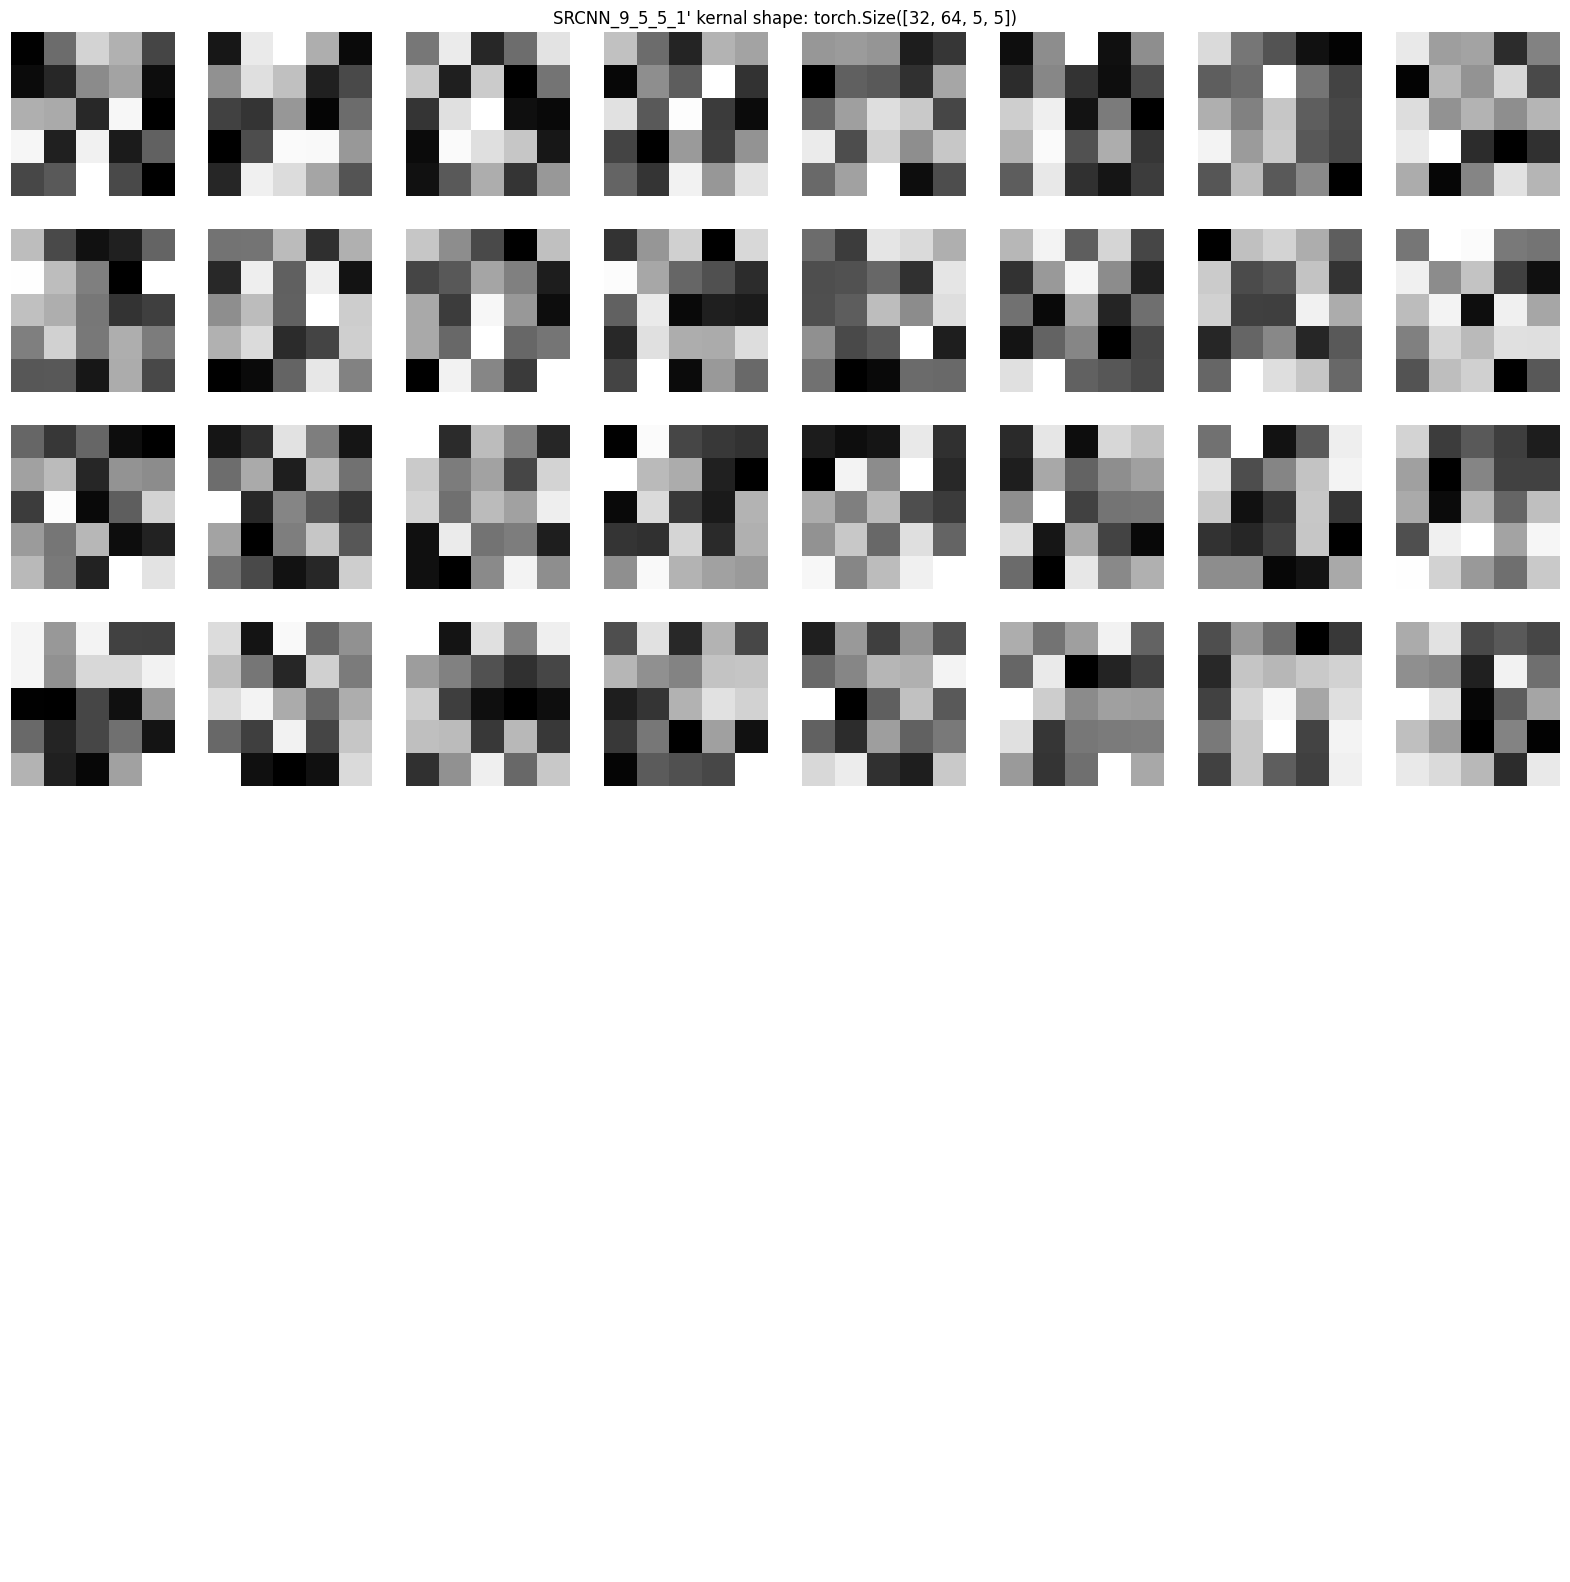

SRCNN_9_5_5_2' kernal shape: torch.Size([1, 32, 5, 5])


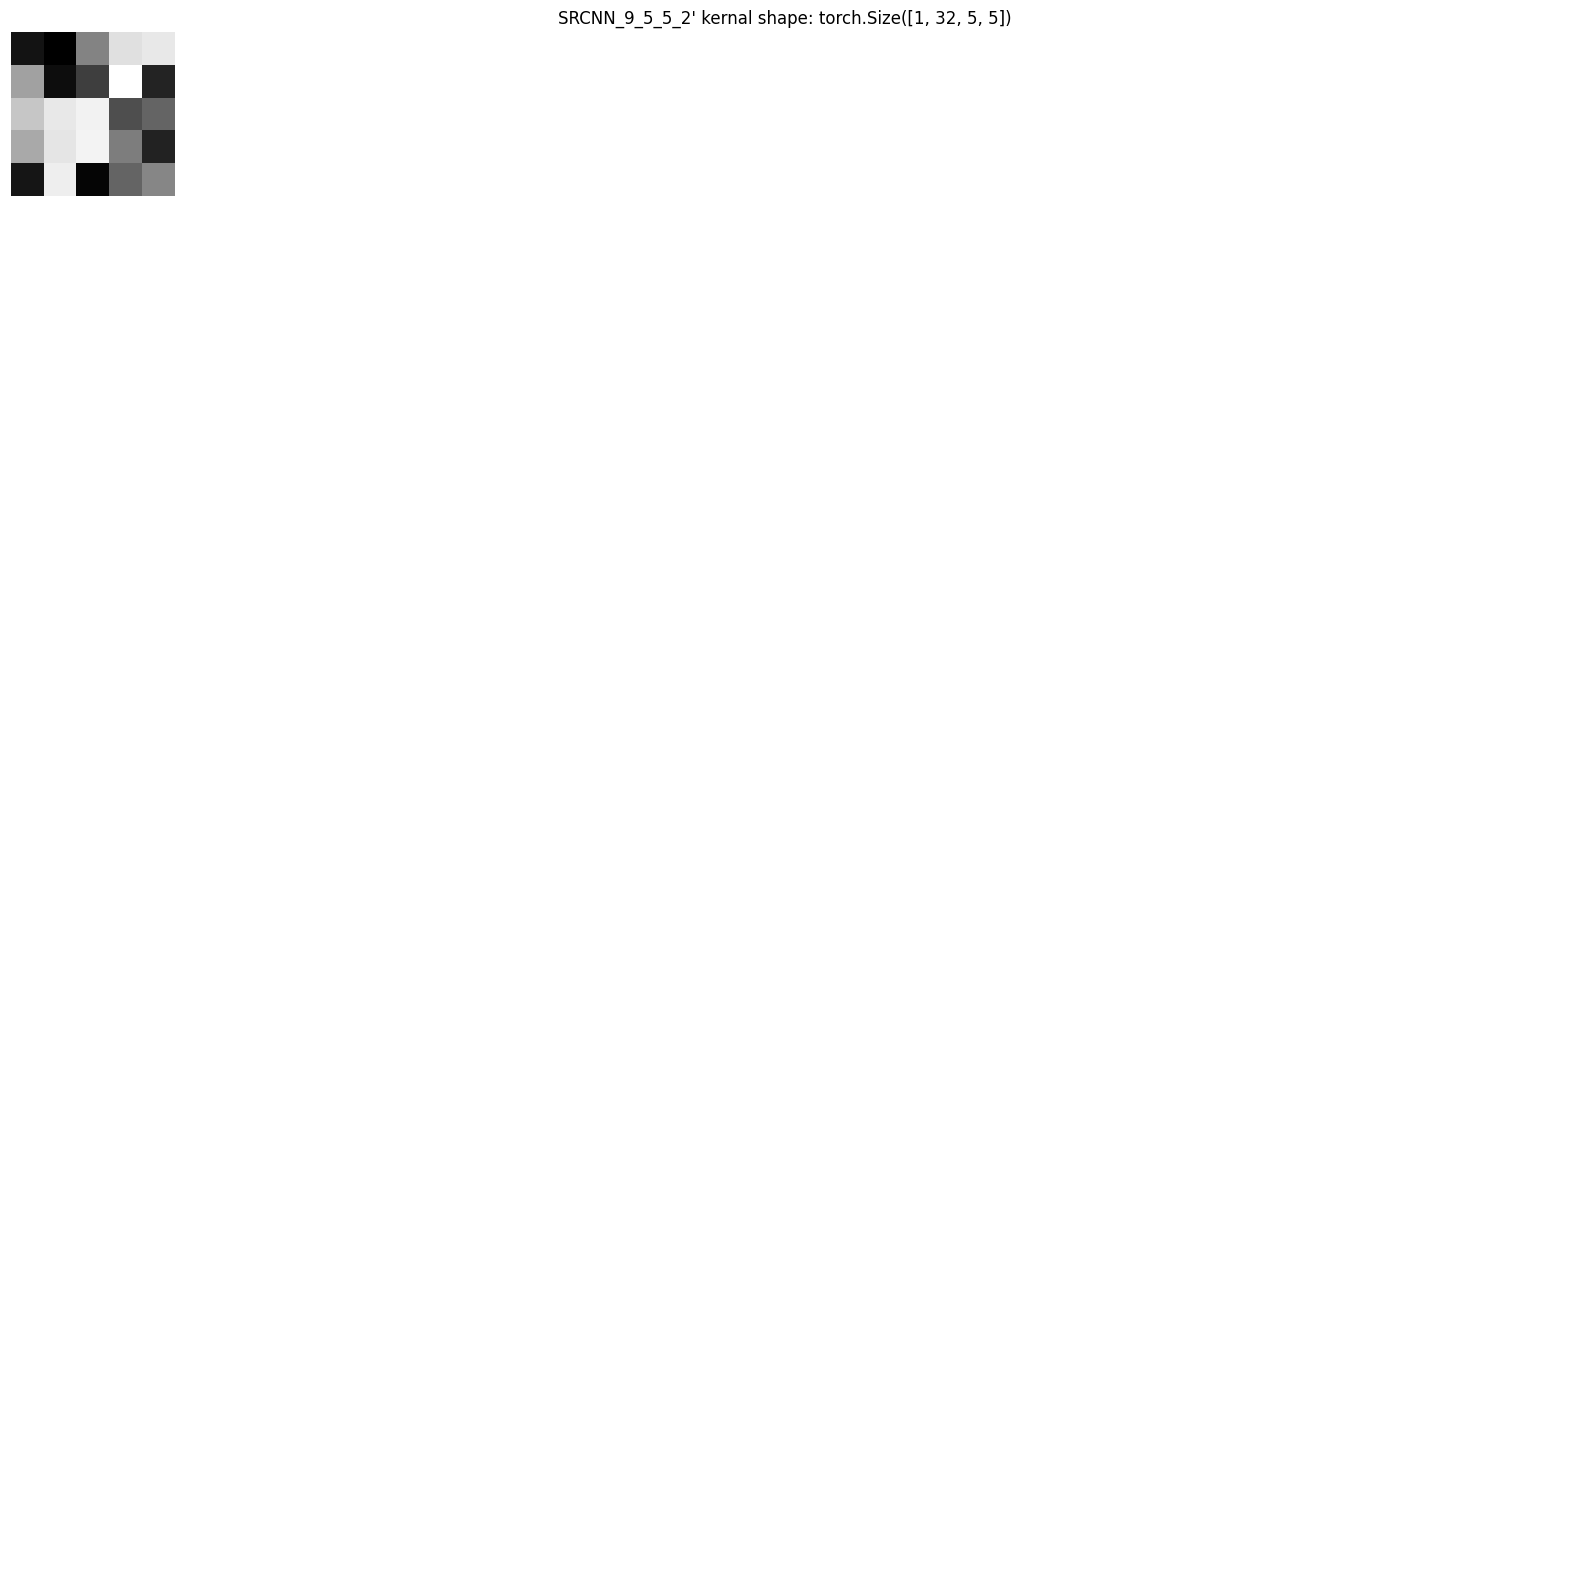

In [40]:
# with torch.no_grad(): 
#     for tag, model in models.items():
#         writer = SummaryWriter(f'runs/SRCNN/{tag}')
#         model = model.to('cpu')
#         model_children = list(model.children())
#         for i in range(len(model_children)):
#             if type(model_children[i]) == nn.Conv2d:
#                 fig = plt.figure(figsize=(64, 64))
#                 model_weights = model_children[i].weight
#                 print(f'{tag}_{i}\' kernal shape: {model_weights.shape}') # torch.Size([64, 1, 9, 9])
#                 plt.title(f'{tag}_{i}\' kernal shape: {model_weights.shape}')
#                 plt.axis('off')
#                 count = 1
#                 for index, filter in enumerate(model_weights):
#                     for idx, fil in enumerate(filter):
#                         fig.add_subplot(64, 64, count)
#                         count += 1
#                         plt.imshow(fil, cmap='gray')
#                         plt.axis('off')
#                 # writer.add_figure(tag=tag, figure=fig, global_step=i)
#                 plt.show()
with torch.no_grad(): 
    for tag, model in models.items():
        writer = SummaryWriter(f'runs/SRCNN/{tag}')
        model = model.to('cpu')
        model_children = list(model.children())
        for i in range(len(model_children)):
            if type(model_children[i]) == nn.Conv2d:
                fig = plt.figure(figsize=(20, 20))
                model_weights = model_children[i].weight
                print(f'{tag}_{i}\' kernal shape: {model_weights.shape}') # torch.Size([64, 1, 9, 9])
                plt.title(f'{tag}_{i}\' kernal shape: {model_weights.shape}')
                plt.axis('off')
                
                for index, filter in enumerate(model_weights):
                    fig.add_subplot(8, 8, index+1)
                    plt.imshow(filter[-1,:,:], cmap='gray')
                    plt.axis('off')
                # writer.add_figure(tag=tag, figure=fig, global_step=i)
                plt.show()
                